---
# Example II - Pricing Risk Simulations
---
This notebook contains steps to simulate Revenue, % US sales, and Upguard Scores through Monte Carlo simulations to generate premiums by holding industry proportions constant.

In [1]:
# install pyarrow dependency for parquet file read/write
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pyarrow

  Using cached pyarrow-10.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.9 MB)


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import johnsonsu

import os
import seaborn as sns

import itertools
import pprint

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
%matplotlib inline 

# Sampling from Distributions
[Numpy](https://numpy.org/doc/stable/reference/random/index.html) and [Scipy](https://docs.scipy.org/doc/scipy/reference/stats.html) random number routines are commonly used to sample from different statistical distributions in Monte Carlo. In this section, we introduce, sample, and visualize results from three distributions for revenue, Upguard score, and US sales

## 1. Revenue
The estimated mean incomes and standard deviations in Australian Bureau of Statistics (ABS) :: Australian business demography statistics will be used to model revenue estimates. A Johnson-SU distribution with mean, Estimated mean income ($m), and standard deviation of between 0.1 to 1, with shape parameters a = -1 and b = 1 will be utilised. An example of Johnson-SU distribution with mean 2.62 and standard deviation of 0.1  is shown below for micro Agriculture, Forestry, and Fishing industry

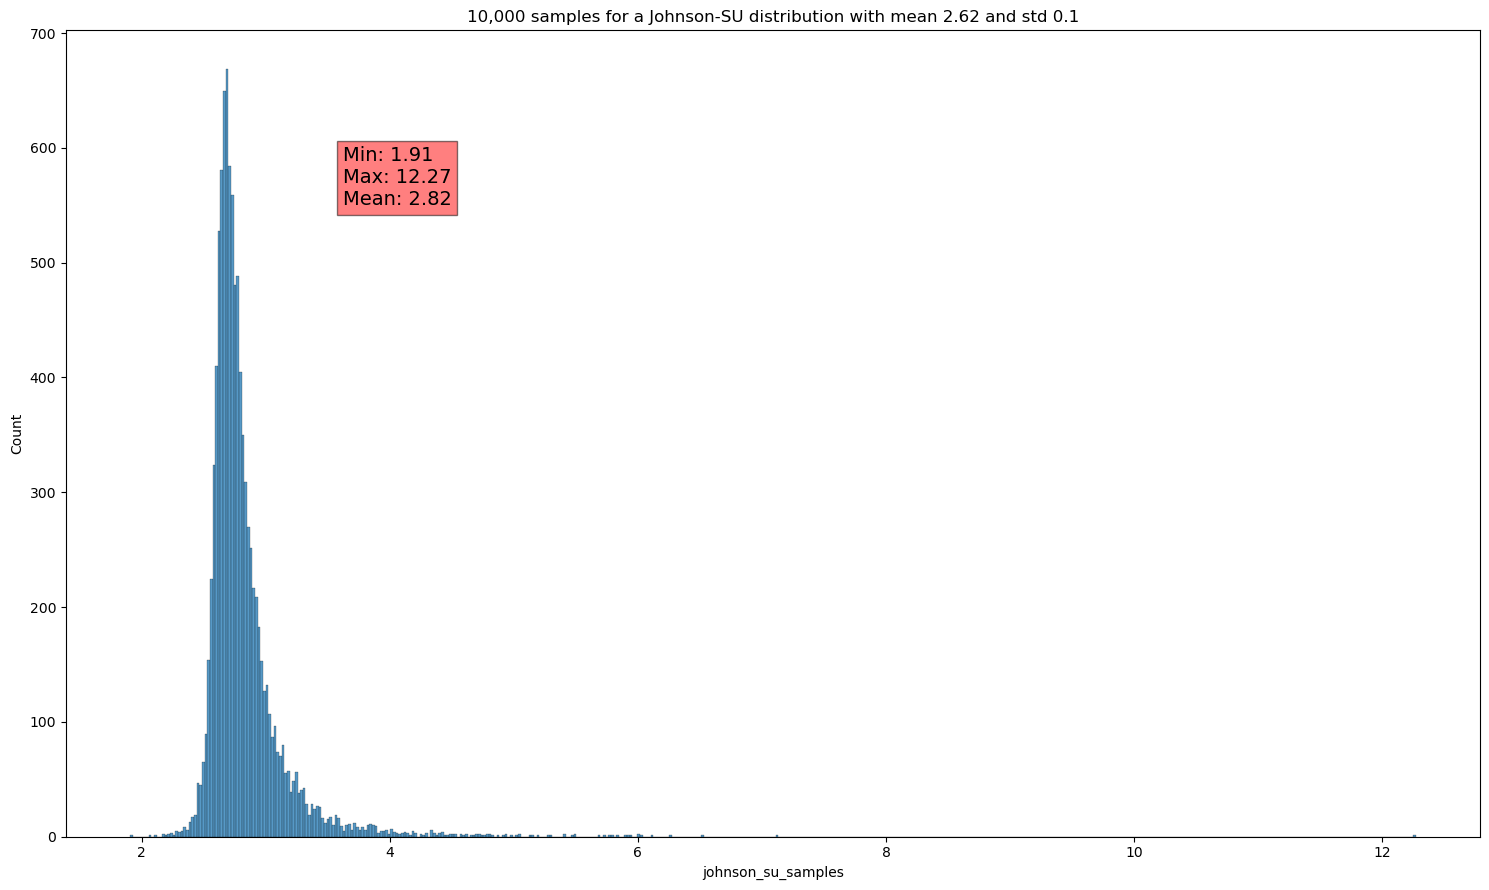

In [3]:
# generate Revenue from Johnson SU distribution
JOHNSON_MEAN = 2.62
JOHNSON_SCALE = 0.1


johnson_su_df = pd.DataFrame(columns=['johnson_su_samples'])
johnson_su_df['johnson_su_samples'] = johnsonsu.rvs(loc=JOHNSON_MEAN,
                                                    scale=JOHNSON_SCALE,
                                                    a=-1, 
                                                    b=1,
                                                    size=10000)

# set values below 0 to zero
johnson_su_df['johnson_su_samples'] = johnson_su_df['johnson_su_samples'].apply(lambda x : x if x > 0 else 0)

# visualise
plt.figure(figsize=(15,9))
sns.histplot(data=johnson_su_df, x="johnson_su_samples")
plt.title(f"10,000 samples for a Johnson-SU distribution with mean {JOHNSON_MEAN} and std {JOHNSON_SCALE}")

# add text
min_ = np.round(min(johnson_su_df.johnson_su_samples), 2)
max_ = np.round(max(johnson_su_df.johnson_su_samples), 2)
mean_ =  np.round(np.mean(johnson_su_df.johnson_su_samples), 2)
stats_txt = f'Min: {min_}\nMax: {max_}\nMean: {mean_}'
plt.text(JOHNSON_MEAN+1, 550, stats_txt, fontsize=14, bbox=dict(facecolor='red', alpha=0.5))

# show plot
plt.tight_layout()
plt.show()

## 2. Upguard Scores 
Upguard scores were reduced to six levels which aligned with the Upguard Adjustment %. These levels were sampled after a discrete normal distribution following the % Sampling Proportion.

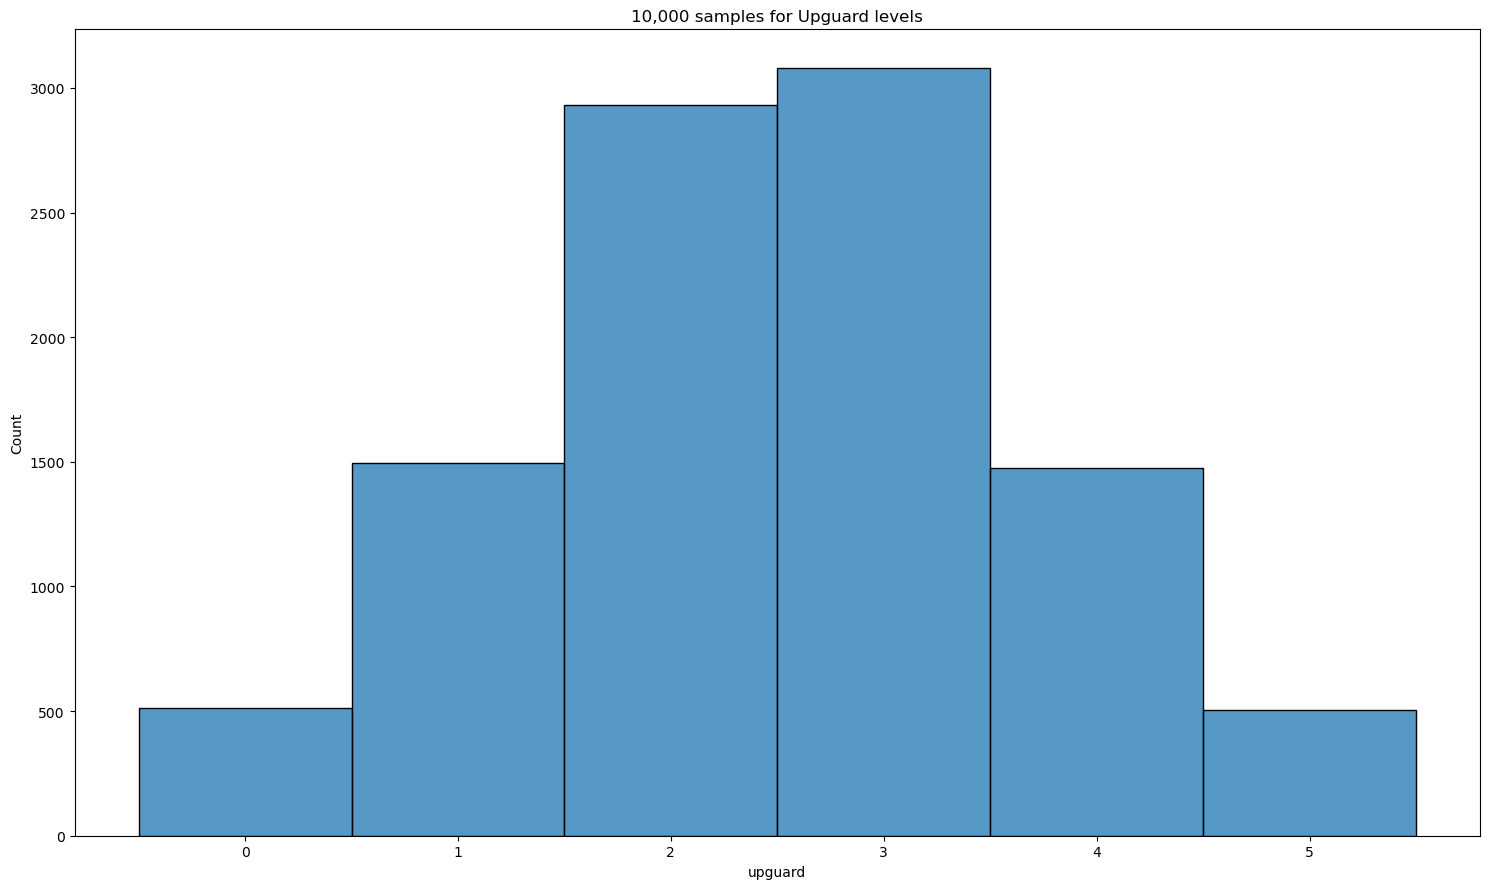

In [4]:
# generate Upguard Scores
upguard_levels_df = pd.DataFrame(columns=['upguard'])
upguard_levels_df['upguard'] =  np.random.choice(6, 10_000, p=[0.05, 0.15, 0.30, 0.30, 0.15, 0.05])

# sns.countplot(data=upguard_levels_df, x="upguard")

plt.figure(figsize=(15,9))
sns.histplot(data=upguard_levels_df, x="upguard", discrete=True)
plt.title(f"10,000 samples for Upguard levels")
plt.tight_layout()
plt.show()

## 3. % US Sales
A uniform distribution was used to model % US Sales and reduced to two categories; with or without US Sales. To add variability, a larger proportion of companies in each industry were assigned w/w/o US Sales instead of assigning all companies. Between 60%-100% of the companies were randomly assigned w/w/o US Sales depending on the nature of US Sales in the industry.

In [5]:
# generate % US Sales from Bernoulli i.e when n = 1 binomial is a Bernoulli trial 
# n is the number of trials i.e. 1
# p is the probability of US Sales
# bernoulli = np.random.binomial(n=1, p=0.2, size=10_000)

# print('MEAN', np.mean(bernoulli))

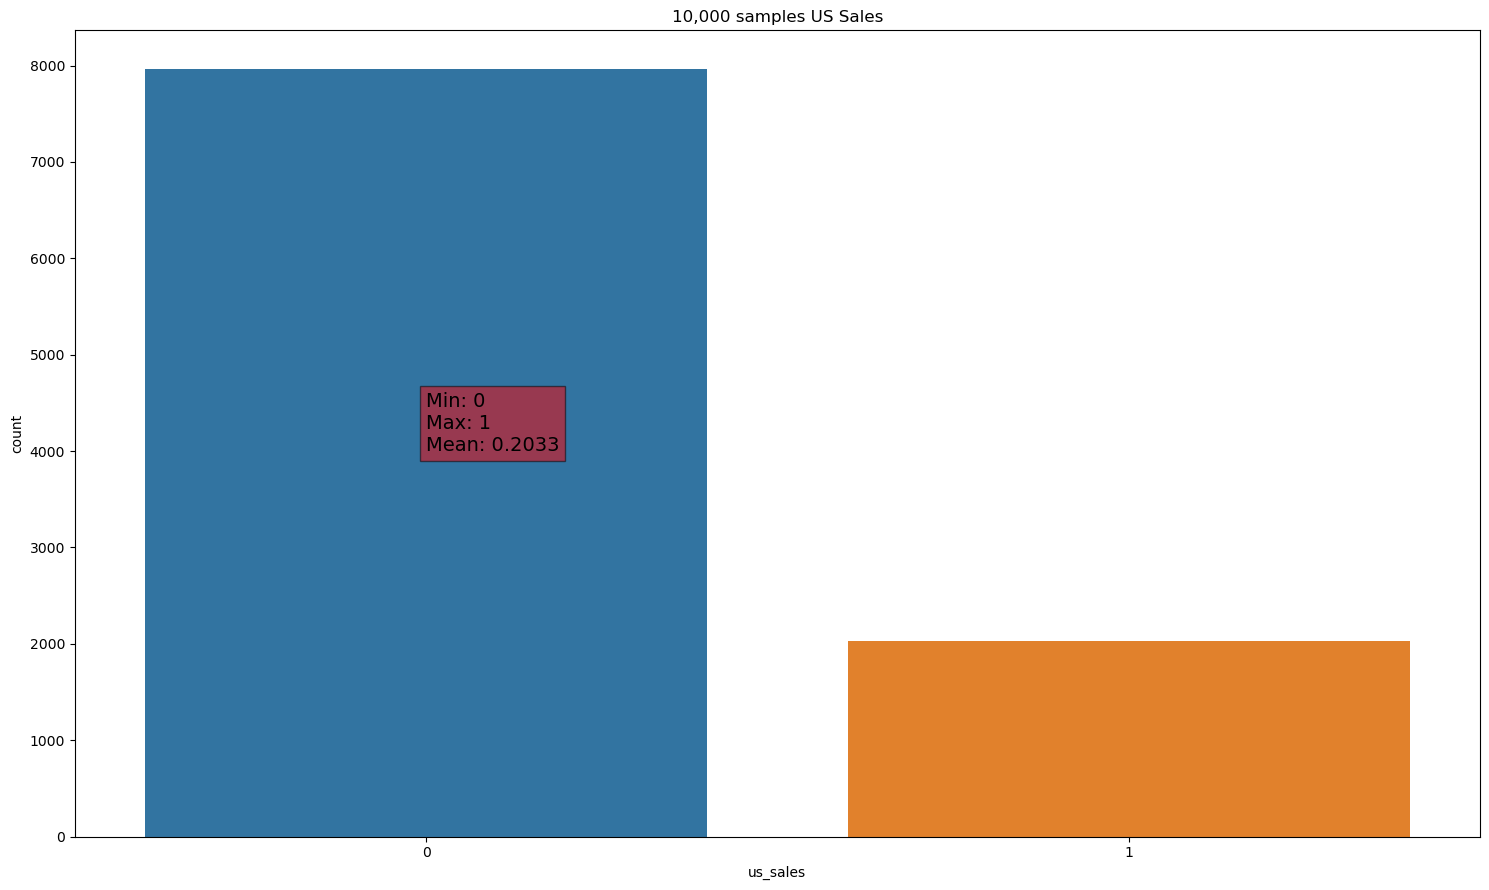

In [6]:
# generate % US Sales from uniform distribution and accept/reject based on probability
PROB = 0.2

us_sales_df = pd.DataFrame(columns=['upguard'])
us_sales_df['us_sales'] = np.random.uniform(0, 1, size=10_000)
us_sales_df['us_sales'] = np.where(us_sales_df['us_sales'] < PROB, 1, 0)

# visualise
plt.figure(figsize=(15,9))
sns.countplot(data=us_sales_df, x="us_sales")
plt.title(f"10,000 samples US Sales")

max_ = max(us_sales_df['us_sales'])
min_ = min(us_sales_df['us_sales'])
mean_ = np.mean(us_sales_df['us_sales'])

stats_txt = f'Min: {min_}\nMax: {max_}\nMean: {mean_}'
plt.text(0, 4000, stats_txt, fontsize=14, bbox=dict(facecolor='red', alpha=0.5))

# show plot
plt.tight_layout()
plt.show()

---


# Cylo Pricing Monte Carlo Simulator

---

## 1. ABS Industry Proportion & Revenue
ABS data on total incomes in 2020-2021 and number of operating businesses in 2022 was the source of truth for SME data. The mean revenue was calculated listed for each business type (micro, small, medium). 

In [7]:
# ABS Revenue Estimates and Counts by ANZ Industry Codes (ANZIC)
abs_mean_revenues = pd.read_csv('Data/abs_tbls/mean_revenue_by_industry.csv')

# create new column which combines industry and sub category
abs_mean_revenues['ANZAC_Sub-Category'] = abs_mean_revenues['ANZAC_Sub-Category'].fillna('All')
abs_mean_revenues['ANZAC_industry-sub'] = abs_mean_revenues['ANZAC_Standard_Industry'] + '_' + abs_mean_revenues['ANZAC_Sub-Category']

# check table
abs_mean_revenues.head()

,ANZAC_Standard_Industry,ANZAC_Sub-Category,Micro_mean,Micro_sd,Small_mean,Small_sd,Medium_mean,Medium_sd,Large,Percentage_Share,Percentage_Micro,Percentage_Small,Percentage_Medium,Percentage_US_Sales,ANZAC_industry-sub
0,"Agriculture, Forestry, and Fishing",All,2.62,0.1,1.66,0.1,5.01,0.1,20.9,0.0720,0.88,0.09,0.02,0.5001,"Agriculture, Forestry, and Fishing_All"
1,Mining,All,0.23,0.1,20.52,0.5,145.72,1.0,"18,101.79",0.0033,0.88,0.09,0.02,0.5001,Mining_All
2,Manufacturing,All,2.16,0.1,5.88,0.1,69.17,1.0,"1,300.25",0.0360,0.88,0.09,0.02,0.5001,Manufacturing_All
3,Services,"Electricity, Gas, Water and Waste Services",0.80,0.1,8.91,0.1,135.58,1.0,"7,092.13",0.0033,0.88,0.09,0.02,0.0000,"Services_Electricity, Gas, Water and Waste Ser..."
4,Services,Construction,2.14,0.1,2.13,0.1,11.35,0.5,127.06,0.1714,0.88,0.09,0.02,0.0000,Services_Construction


## 2. Cylo and ABS Industry Groups
There are differences in how Cylo and ABS industries are recorded. An attempt was made to map the industries between Cylo and ABS.

#### Data definitions
- _ANZAC_industry-sub_parameter_combination_ is a unique ID for each ABS-Cylo-Industry-Parameter combination
- _Industry_ is the Cylo industry categories
- _Sub-Category_Count_ is the number of sub-industries within each each ABS-Cylo-Industry-Parameter combination
- _ANZAC_Standard_Industry_ is ABS industry categories
- _ANZAC_Sub-Category_ is ABS industry sub categories

In [8]:
# Load cylo and abs mapping table
cylo_to_abs_industry_df = pd.read_csv('Data/parameter_tbls/cylo_abs_industry_mapping.csv')

# check table
cylo_to_abs_industry_df.head()

,ANZAC_industry-sub_parameter_combination,Industry,Sub-Category_Count,ANZAC_Standard_Industry,ANZAC_Sub-Category,ANZAC_industry-sub
0,1,"Agriculture, Forestry, and Fishing",8,"Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing_All"
1,2,"Banks, Finance, Insurance, and Investment",3,Services,Financial and Insurance Services,Services_Financial and Insurance Services
2,3,"Banks, Finance, Insurance, and Investment",18,Services,Financial and Insurance Services,Services_Financial and Insurance Services
3,4,Communications and Telecoms,1,Services,Information Media and Telecommunications,Services_Information Media and Telecommunications
4,5,Communications and Telecoms,7,Services,Information Media and Telecommunications,Services_Information Media and Telecommunications


In [9]:
# get unique groups
unique_industry_categories = cylo_to_abs_industry_df['ANZAC_industry-sub'].drop_duplicates()
unique_industry_categories.values

array(['Agriculture, Forestry, and Fishing_All',
       'Services_Financial and Insurance Services',
       'Services_Information Media and Telecommunications',
       'Services_Construction', 'Manufacturing_All',
       'Services_Retail Trade', 'Services_Wholesale Trade', 'Mining_All',
       'Services_Other Services',
       'Services_Health Care and Social Assistance',
       'Services_Arts and Recreation Services',
       'Services_Education and Training',
       'Services_Public Administration and Safety',
       'Services_Professional, Scientific and Technical Services',
       'Services_Rental, Hiring and Real Estate Services',
       'Services_Accommodation and Food Services',
       'Services_Administrative and Support Services',
       'Services_Transport, Postal and Warehousing',
       'Services_Electricity, Gas, Water and Waste Services'],
      dtype=object)

## 3. Monte Carlo Simulation

### Psuedo Code

```python
num_scenarios = 1,000
num_samples = 100,000
num_samples_per_industry = num_samples * industry_proportions
  
while num_scenarios:
    For num_samples_per_industry:
        For business_type:
            1.  Sample revenues
            2.  Sample % US Sales
            3.  Sample Upguard Levels
            4.  Get base premium using tables and calculate adjusted premiums - Step is omitted because sensitivities
            5.  Aggregate and analyse results
```

In [10]:
# specify number of samples and scenarios
num_scenarios = 1_0 # 1_000
num_samples = 100_000
scenario_counter = 0

# generate number of samples per industry
abs_mean_revenues['num_samples_per_industry'] = num_samples * abs_mean_revenues.Percentage_Share

# save directory
main_scenario_dir = 'Data/monte_carlo_scenarios'

while scenario_counter < num_scenarios:
    scenario_dir = os.path.join(main_scenario_dir, f'scenario_{scenario_counter}')
    os.makedirs(scenario_dir, exist_ok=True)

    for cat in unique_industry_categories:
        tmp = cylo_to_abs_industry_df[cylo_to_abs_industry_df['ANZAC_industry-sub'] == cat].copy()
        abs_mean_revenue_category = abs_mean_revenues[abs_mean_revenues['ANZAC_industry-sub'] == cat].copy()
        total_samples_in_industry = int(abs_mean_revenue_category['num_samples_per_industry'])


        if cat not in ['Services_Financial and Insurance Services']:
            # CASE 1: one to one industry mapping cases
            if len(tmp) == 1:
                tmp.loc[:, 'samples_in_industry'] = total_samples_in_industry
            
            # CASE 2: one to many industry mapping cases as a result of different parameter combinations
            if len(tmp) > 1 and cat not in ['Services_Professional, Scientific and Technical Services']:
                tmp.loc[:, 'samples_in_industry'] = tmp['Sub-Category_Count']/sum(tmp['Sub-Category_Count']) * total_samples_in_industry
                tmp.loc[:, 'samples_in_industry'] =  tmp['samples_in_industry'].astype(int)
                total_samples_in_industry = sum(tmp['samples_in_industry'])
                
            # CASE 3: one to many industry mapping cases for professional services only
            if cat in ['Services_Professional, Scientific and Technical Services']:
                # set lower proportion to public admin categories
                public_admin_proportion = np.round(np.random.uniform(0.05, 0.3, size=1), 2)[0]
                samples_in_public_admin = public_admin_proportion * total_samples_in_industry
                samples_in_services = total_samples_in_industry - samples_in_public_admin

                # create default & update samples in industry
                tmp.loc[:,'samples_in_industry'] =  np.array([0]*len(tmp))

                # Public Administration
                samples_per_subcat_public = tmp[tmp['Industry']=='Public Administration']['Sub-Category_Count']/sum(tmp[tmp['Industry']=='Public Administration']['Sub-Category_Count']) * samples_in_public_admin
                tmp.loc[tmp['Industry'] == 'Public Administration', ['samples_in_industry']] = samples_per_subcat_public.astype(int)

                # Services
                samples_per_subcat_services = tmp[tmp['Industry']=='Services']['Sub-Category_Count']/sum(tmp[tmp['Industry']=='Services']['Sub-Category_Count']) * samples_in_services
                tmp.loc[tmp['Industry'] == 'Services', ['samples_in_industry']] = samples_per_subcat_services.astype(int)

                total_samples_in_industry = sum(tmp['samples_in_industry'])

            # initialize lists
            ANZAC_industry_sub_ls = []
            ANZAC_Industry_ls = []
            ANZAC_Sub_Category_ls = []
            Industry_ls = []
            business_type_ls = []
            revenues_ls = []
            us_sales_ls = []
            upguard_levels_ls = []

            # main simulation loop
            for i in range(len(tmp)):
                samples_in_industry = int(tmp['samples_in_industry'][i:i+1])

                # get number of businesses by SME
                num_micro_business = int(samples_in_industry * abs_mean_revenue_category['Percentage_Micro'])
                num_small_business = int(samples_in_industry * abs_mean_revenue_category['Percentage_Small'])
                num_med_business = int(samples_in_industry - num_micro_business - num_small_business)

                # simulate revenue by SME
                revenues_micro_business = johnsonsu.rvs(loc=abs_mean_revenue_category['Micro_mean'], scale=abs_mean_revenue_category['Micro_sd'], a=-1, b=1, size=num_micro_business) * 1_000_000
                revenues_small_business = johnsonsu.rvs(loc=abs_mean_revenue_category['Small_mean'], scale=abs_mean_revenue_category['Small_sd'], a=-1, b=1, size=num_small_business) * 1_000_000
                revenues_medium_business = johnsonsu.rvs(loc=abs_mean_revenue_category['Medium_mean'], scale=abs_mean_revenue_category['Medium_sd'], a=-1, b=1, size=num_med_business) * 1_000_000

                # simulate US Sales
                us_sales = np.random.uniform(0, 1, size=samples_in_industry)
                acceptance_prob = np.round(np.random.uniform(0.6, 1.0, size=1),2)[0]
                us_sales_prob = acceptance_prob if abs_mean_revenue_category['Percentage_US_Sales'].values > 0.5 else 1-acceptance_prob
                us_sales = np.where(us_sales < us_sales_prob, 0.5, 0)

                # simulate Upguard
                upguard_levels = np.random.choice(6, samples_in_industry, p=[0.05, 0.15, 0.3, 0.3, 0.15, 0.05])

                # update lists
                ANZAC_industry_sub_ls.extend([cat]*samples_in_industry)
                ANZAC_Industry_ls.extend(tmp['ANZAC_Standard_Industry'][i:i+1].values.tolist()*samples_in_industry)
                ANZAC_Sub_Category_ls.extend(tmp['ANZAC_Sub-Category'][i:i+1].values.tolist()*samples_in_industry)
                Industry_ls.extend(tmp[i:i+1]['Industry'].values.tolist()*samples_in_industry)
                business_type_ls.extend(['micro']*num_micro_business + ['small']*num_small_business + ['medium']*num_med_business)
                revenues_ls.extend(list(itertools.chain(revenues_micro_business, revenues_small_business, revenues_medium_business)))
                us_sales_ls.extend(us_sales)
                upguard_levels_ls.extend(upguard_levels)

            # create simulated dataset
            industry_df = {'ANZAC_industry-sub': ANZAC_industry_sub_ls,
                           'ANZAC_Industry': ANZAC_Industry_ls, 
                           'ANZAC_Sub-Category': ANZAC_Sub_Category_ls,
                           'Industry': Industry_ls,
                           'business_type': business_type_ls,
                           'revenues': revenues_ls,
                           'us_sales': us_sales_ls,
                           'upguard_levels': upguard_levels_ls}

            # save simulated dataset 
            industry_df = pd.DataFrame(industry_df)
            industry_file_name = cat.replace(',','').replace(' ', '_')
            industry_df.to_parquet(os.path.join(scenario_dir, f'{industry_file_name}.parquet.gzip'), compression='gzip')

#     update scenario counter
    scenario_counter += 1

## Check Simulation Outputs

In [11]:
# specify scenario
SCENARIO_NUM = 0
INDUSTRY = 'Agriculture_Forestry_and_Fishing_All'


# read and show file
samples_df = pd.read_parquet(f'{main_scenario_dir}/scenario_{SCENARIO_NUM}/{INDUSTRY}.parquet.gzip')
samples_df

,ANZAC_industry-sub,ANZAC_Industry,ANZAC_Sub-Category,Industry,business_type,revenues,us_sales,upguard_levels
0,"Agriculture, Forestry, and Fishing_All","Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing",micro,2.596497e+06,0.5,3
1,"Agriculture, Forestry, and Fishing_All","Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing",micro,2.789664e+06,0.0,2
2,"Agriculture, Forestry, and Fishing_All","Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing",micro,2.672577e+06,0.5,2
3,"Agriculture, Forestry, and Fishing_All","Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing",micro,2.828392e+06,0.5,5
4,"Agriculture, Forestry, and Fishing_All","Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing",micro,2.821512e+06,0.5,2
...,...,...,...,...,...,...,...,...
7194,"Agriculture, Forestry, and Fishing_All","Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing",medium,5.259831e+06,0.5,3
7195,"Agriculture, Forestry, and Fishing_All","Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing",medium,5.091865e+06,0.0,1
7196,"Agriculture, Forestry, and Fishing_All","Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing",medium,5.148245e+06,0.5,4
7197,"Agriculture, Forestry, and Fishing_All","Agriculture, Forestry, and Fishing",All,"Agriculture, Forestry, and Fishing",medium,5.004672e+06,0.5,2
